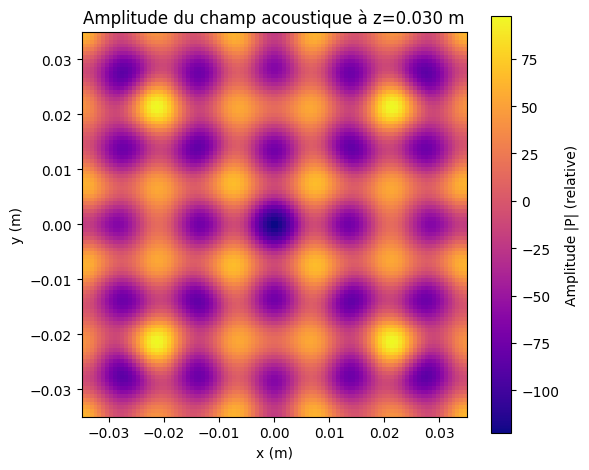

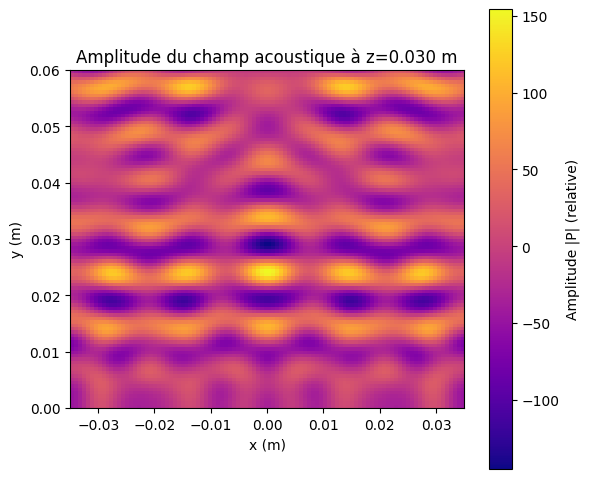

In [ ]:
import numpy as np
import math as m
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# ---- Constantes physiques ----
k = 2 * m.pi * 40000 / 343
R_p = 0.0005
c_p = 2400
rho_p = 28.59
c_0 = 343
rho_0 = 1.204
R_t = 0.005  # rayon transducteur

eps = 1e-4  # pas de dérivation

# Point de focalisation :
X_foc, Y_foc, Z_foc = 0, 0, 0.03  # altitude où on focalise

# Grille des transducteurs
a = 0.01
n = 8
N_trans=64

# bornes symétriques : +/-5 cm latéralement, 8 cm en hauteur
Lx = 0.05
Ly = 0.05
DzT=0.08

x = np.linspace(-Lx, Lx, n)
y = np.linspace(-Ly, Ly, n)

X_j, Y_j = np.meshgrid(x, y)
Z_j=np.array([[0]*n]*n)

##on passe tout à une dimension, dans le ref de la plaque :
X_j=X_j.flatten()
Y_j=Y_j.flatten()
Z_j=Z_j.flatten()

# ---- Fonctions utilitaires (vectorisées) ----

def d(xj, yj, zj, xf, yf, zf):
    return np.sqrt((xj - xf)**2 + (yj - yf)**2 + (zj - zf)**2)

def D_F(xj, yj, zj, x, y, z):
    # distance radiale par rapport à l'axe z
    rho = np.sqrt((x - xj)**2 + (y - yj)**2)
    dz = (z - zj)

    denom = np.sqrt(rho**2 + dz**2)
    # si denom == 0, sin(theta)=0 => on veut retour 1 (limite)
    sin_theta = np.where(denom == 0, 0.0, rho / denom)
    arg = k * R_t * sin_theta

    # sinc(x) = sin(x)/x ; définir sinc(0)=1
    with np.errstate(invalid='ignore', divide='ignore'):
        sinc = np.where(arg == 0, 1.0, np.sin(arg) / arg)

    # Si dz == 0, on choisit de renvoyer 1 (comme dans ton code original)
    sinc = np.where(dz == 0, 1.0, sinc)
    return sinc

def K1(R, c_p, rho_p):
    V = 4 * np.pi / 3 * R**3
    a0 = 1 / (c_0**2 * rho_0)
    ap = 1 / (c_p**2 * rho_p)
    return V / 4 * (a0 - ap)

def K2(R, omega, rho_p):
    V = 4 * np.pi / 3 * R**3
    return 3 * V / 4 * ((rho_0 - rho_p) / (omega**2 * rho_0 * (rho_0 + 2 * rho_p)))

def f(xj, yj, zj, x, y, z, phi,ampl):
    dj = d(xj, yj, zj, x, y, z)
    DF = D_F(xj, yj, zj, x, y, z)
    # éviter division par zéro sur dj
    with np.errstate(divide='ignore', invalid='ignore'):
        res = DF / dj * np.exp(1j * (k * dj + phi))
        # si dj == 0 (rare), on peut définir limite : DF/dj ~ infinite -> set to 0
        res = np.where(dj == 0, 0.0 + 0.0j, res)
    return ampl*res

# ---- Calcul du champ total (vectorisé sur x,y,z) ----
def p_tot(x, y, z, phi_vals,ampl):

    # initialiser p total: type complexe, shape = broadcast(x,y,z)
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    out_shape = np.broadcast(x, y, z).shape
    ptot = np.zeros(out_shape, dtype=np.complex128)

    # sommation en boucle sur transducteurs (vectorisé spatialement)
    for i in range(N_trans):
        ptot += f(X_j[i], Y_j[i], Z_j[i], x, y, z, phi_vals[i],ampl[i])

    return ptot

# ---- Code d'affichage / usage ----
b = 100  # nombre de point d'affichage

# Phases (exemple importé)

Phi = np.array([0.16057536, 0.02658712, 0.03717466, 5.95503812, 5.95503812,
       0.03717475, 0.02658713, 0.1605754 , 0.02658713, 5.95503812,
       0.33026945, 6.17476676, 6.17476671, 0.33026945, 5.95503813,
       0.02658713, 0.03717471, 0.33026945, 5.93175305, 0.37400245,
       0.37400245, 5.93175306, 0.33026945, 0.0371748 , 5.95503812,
       6.17476666, 0.37400246, 6.13925298, 6.13925304, 0.3740024 ,
       6.17476677, 5.95503813, 5.95503813, 6.17476671, 0.37400245,
       6.13925304, 6.13925304, 0.3740024 , 6.17476676, 5.95503814,
       0.03717476, 0.33026941, 5.93175306, 0.3740024 , 0.3740024 ,
       5.93175303, 0.33026944, 0.03717481, 0.02658708, 5.95503813,
       0.33026945, 6.17476676, 6.17476676, 0.33026945, 5.95503812,
       0.02658705, 0.1605754 , 0.02658708, 0.03717476, 5.95503814,
       5.95503813, 0.0371748 , 0.02658704, 0.16057544])
ampl=np.array([1]*n**2)





def coupe_horizontale(Z_a, D_a=0.035):
    x = np.linspace(-D_a, D_a, b)
    y = np.linspace(-D_a, D_a, b)
    X_grid, Y_grid = np.meshgrid(x, y)
    Z_grid = np.full_like(X_grid, Z_a)

    amp = p_tot(X_grid, Y_grid, Z_grid, Phi,ampl)

    plt.figure(figsize=(6, 5))
    plt.imshow(amp.real, extent=[-D_a, D_a, -D_a, D_a],
               origin='lower', cmap='plasma')  # utiliser la partie réelle du potentiel
    plt.colorbar(label='Amplitude |P| (relative)')
    plt.title(f'Amplitude du champ acoustique à z={Z_a:.3f} m')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.tight_layout()
    plt.show()


def coupe_verticale(Z_a, D_a=0.035):
    x = np.linspace(-D_a, D_a, b)
    z = np.linspace(0.0001, 2*Z_a, b)
    X_grid, Z_grid = np.meshgrid(x, z)
    Y_grid = np.full_like(X_grid, 0)

    amp = p_tot(X_grid, Y_grid, Z_grid, Phi,ampl)

    plt.figure(figsize=(6, 5))
    plt.imshow(amp.real, extent=[-D_a, D_a, 0, 2*Z_a],
               origin='lower', cmap='plasma')  # utiliser la partie réelle du potentiel
    plt.colorbar(label='Amplitude |P| (relative)')
    plt.title(f'Amplitude du champ acoustique à z={Z_a:.3f} m')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.tight_layout()
    plt.show()

# Lancer l'affichage
if __name__ == "__main__":
    coupe_horizontale(0.03)
    coupe_verticale(0.03)

trace force

In [ ]:
def D_F_vectorized(xj, yj, zj, x, y, z):
    theta = np.arctan(np.sqrt((x - xj)**2 + (y - yj)**2) / np.where(np.abs(z - zj) < 1e-12, 1e-12, np.abs(z - zj)))
    df = np.sin(k * R_p * np.sin(theta)) / np.where(np.sin(k * R_p * np.sin(theta)) == 0, 1e-12, k * R_p * np.sin(theta))
    df = np.where(np.isnan(df), 1, df)
    return df

# === Calcul du champ total ===

def p_tot(x, y, z, phi_vals, dj, df):
    exp_term = np.exp(1j * (k * dj + phi_vals))
    return np.sum(df / dj * exp_term)

# === Pré-calculs (ne dépendent pas des phases) ===
DJ={}
DF={}
def precompute_field_params(x, y, z):
    # Plaque du bas
    if (x,y,z) in DJ:
        return (DJ[(x,y,z)],DF[(x,y,z)])

    else :
      dx = X_j - x
      dy = Y_j - y
      dz = Z_j - z
      dj = np.sqrt(dx**2 + dy**2 + dz**2)
      df = D_F_vectorized(X_j, Y_j, Z_j, x, y, z)
      DJ[(x,y,z)]=dj
      DF[(x,y,z)]=df

      return (dj, df)

# === Gradient numérique du champ ===

def grad_p(x, y, z, phi_vals, dj0, df0):
    def shifted_p(dx, dy, dz):
        dj, df = precompute_field_params(x + dx, y + dy, z + dz)
        return p_tot(x + dx, y + dy, z + dz, phi_vals, dj, df)

    dp_dx = (shifted_p(eps, 0, 0) - shifted_p(0, 0, 0)) / eps
    dp_dy = (shifted_p(0, eps, 0) - shifted_p(0, 0, 0)) / eps
    dp_dz = (shifted_p(0, 0, eps) - shifted_p(0, 0, 0)) / eps
    return np.array([dp_dx, dp_dy, dp_dz])

# === Potentiel de Gorkov ===

def gorkov_potential(x, y, z, phi_vals, dj, df):
    p_complex = p_tot(x, y, z, phi_vals, dj, df)
    gradp = grad_p(x, y, z, phi_vals, dj, df)

    omega = 2 * np.pi * 40000
    k1 = K1(R_p, c_p, rho_p)
    k2 = K2(R_p, omega, rho_p)

    abs_p2 = abs(p_complex)**2
    abs_gradp2 = np.sum(np.abs(gradp)**2)
    return k1 * abs_p2 - k2 * abs_gradp2

# === Laplacien du potentiel ===

def Fz(x, y, z, phi_vals):
    def U_shift(dx, dy, dz):
        dj, df = precompute_field_params(x + dx, y + dy, z + dz)
        return gorkov_potential(x + dx, y + dy, z + dz, phi_vals, dj, df)

    dU_dz = (U_shift(0, 0, eps) - U_shift(0, 0, 0)) / eps
    return dU_dz

def force_verticale(Z_a, D_a=0.035):
    Z = np.linspace(0.0001, 2*Z_a, b)
    amp=[]
    for a in Z :
      amp.append (Fz(X_foc, Y_foc, a, Phi))

    plt.figure(figsize=(6, 5))
    plt.plot(Z,amp)
    plt.title(f'evolution de la force selon z')
    plt.xlabel('z (m)')
    plt.ylabel('F')
    plt.grid()
    plt.show()

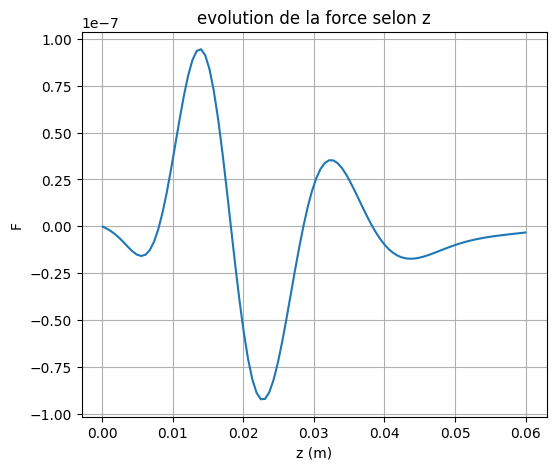

In [ ]:
force_verticale(0.03)

**avec deux plaque :**

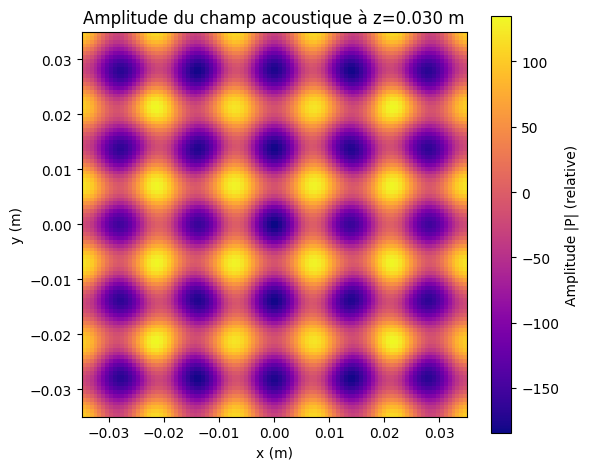

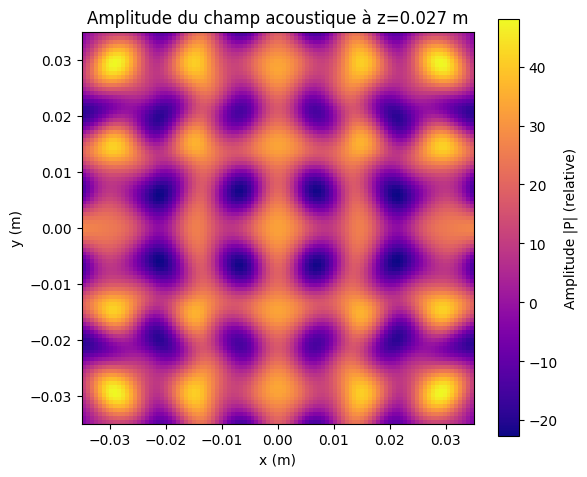

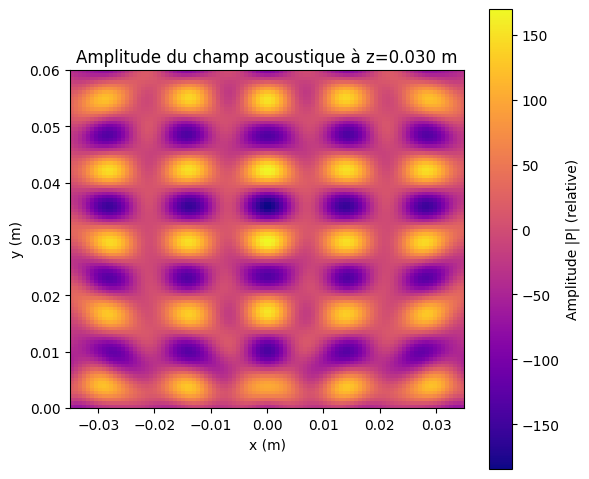

In [95]:
# Point de focalisation :
X_foc, Y_foc, Z_foc = 0, 0, 0.03  # altitude où on focalise

# Grille des transducteurs
a = 0.01
n = 8

# bornes symétriques : +/-5 cm latéralement, 8 cm en hauteur
Lx = 0.05
Ly = 0.05
DzT=0.08

x = np.linspace(-Lx, Lx, n)
y = np.linspace(-Ly, Ly, n)

X_j, Y_j = np.meshgrid(x, y)
Z_j=np.array([[0]*n]*n)

##on passe tout à une dimension, dans le ref de la plaque :
X_j=X_j.flatten()
Y_j=Y_j.flatten()
Z_j=Z_j.flatten()
N_trans = X_j.size

# Deuxième grille (quinconce)
Z2 = 0.06     # altitude
# bornes symétriques : +/-5 cm latéralement, 8 cm en hauteur
Lx = 0.05
Ly = 0.05
DzT=0.08

x = np.linspace(-Lx, Lx, n)
y = np.linspace(-Ly, Ly, n)

X2_j, Y2_j = np.meshgrid(x, y)
Z2_j=np.array([[Z2]*n]*n)

##on passe tout à une dimension, dans le ref de la plaque :
X2_j=X2_j.flatten()
Y2_j=Y2_j.flatten()
Z2_j=Z2_j.flatten()
N_trans2 = X2_j.size

# ---- Fonctions utilitaires (vectorisées) ----

def d(xj, yj, zj, xf, yf, zf):
    return np.sqrt((xj - xf)**2 + (yj - yf)**2 + (zj - zf)**2)

def D_F(xj, yj, zj, x, y, z):
    # distance radiale par rapport à l'axe z
    rho = np.sqrt((x - xj)**2 + (y - yj)**2)
    dz = (z - zj)

    denom = np.sqrt(rho**2 + dz**2)
    # si denom == 0, sin(theta)=0 => on veut retour 1 (limite)
    sin_theta = np.where(denom == 0, 0.0, rho / denom)
    arg = k * R_t * sin_theta

    # sinc(x) = sin(x)/x ; définir sinc(0)=1
    with np.errstate(invalid='ignore', divide='ignore'):
        sinc = np.where(arg == 0, 1.0, np.sin(arg) / arg)

    # Si dz == 0, on choisit de renvoyer 1 (comme dans ton code original)
    sinc = np.where(dz == 0, 1.0, sinc)
    return sinc

def K1(R, c_p, rho_p):
    V = 4 * np.pi / 3 * R**3
    a0 = 1 / (c_0**2 * rho_0)
    ap = 1 / (c_p**2 * rho_p)
    return V / 4 * (a0 - ap)

def K2(R, omega, rho_p):
    V = 4 * np.pi / 3 * R**3
    return 3 * V / 4 * ((rho_0 - rho_p) / (omega**2 * rho_0 * (rho_0 + 2 * rho_p)))

def f(xj, yj, zj, x, y, z, phi,ampl):
    dj = d(xj, yj, zj, x, y, z)
    DF = D_F(xj, yj, zj, x, y, z)
    # éviter division par zéro sur dj
    with np.errstate(divide='ignore', invalid='ignore'):
        res = DF / dj * np.exp(1j * (k * dj + phi))
        # si dj == 0 (rare), on peut définir limite : DF/dj ~ infinite -> set to 0
        res = np.where(dj == 0, 0.0 + 0.0j, res)
    return ampl*res

# ---- Calcul du champ total (vectorisé sur x,y,z) ----
def p_tot(x, y, z, phi_vals,ampl):

    # initialiser p total: type complexe, shape = broadcast(x,y,z)
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    out_shape = np.broadcast(x, y, z).shape
    ptot = np.zeros(out_shape, dtype=np.complex128)

    # sommation en boucle sur transducteurs (vectorisé spatialement)
    for i in range(N_trans):
        ptot += f(X_j[i], Y_j[i], Z_j[i], x, y, z, phi_vals[i],ampl[i])
    for i in range(N_trans2):
        ptot += f(X2_j[i], Y2_j[i], Z2_j[i], x, y, z, phi_vals[i+N_trans],ampl[i+N_trans])
    return ptot

# ---- Code d'affichage / usage ----
b = 100  # nombre de point d'affichage

# Phases (exemple importé)
Phi = np.array([6.27593158e+00, 6.20738473e+00, 1.54858542e-01, 1.13146827e-01,
       1.13146826e-01, 1.54858541e-01, 6.20738473e+00, 6.27593158e+00,
       4.63613553e-02, 6.21567427e+00, 6.23559348e+00, 1.64551988e-03,
       1.64551456e-03, 6.23559352e+00, 6.21567426e+00, 4.63613532e-02,
       6.11062364e+00, 3.03696050e-03, 6.20504909e+00, 6.23250862e+00,
       6.23250864e+00, 6.20504913e+00, 3.03697767e-03, 6.11062364e+00,
       2.06580747e-01, 6.24680425e+00, 1.61344666e-01, 6.28011762e+00,
       6.28011762e+00, 1.61344651e-01, 6.24680423e+00, 2.06580749e-01,
       2.06580748e-01, 6.24680423e+00, 1.61344665e-01, 6.28011761e+00,
       6.28011761e+00, 1.61344653e-01, 6.24680425e+00, 2.06580749e-01,
       6.11062364e+00, 3.03696402e-03, 6.20504912e+00, 6.23250863e+00,
       6.23250864e+00, 6.20504912e+00, 3.03695820e-03, 6.11062362e+00,
       4.63613687e-02, 6.21567427e+00, 6.23559348e+00, 1.64551808e-03,
       1.64552066e-03, 6.23559351e+00, 6.21567427e+00, 4.63613518e-02,
       6.27593156e+00, 6.20738473e+00, 1.54858547e-01, 1.13146825e-01,
       1.13146825e-01, 1.54858545e-01, 6.20738473e+00, 6.27593156e+00,
       6.48171509e-03, 1.42099117e-01, 6.23675072e+00, 6.14816581e+00,
       6.14816580e+00, 6.23675069e+00, 1.42099133e-01, 6.48171799e-03,
       9.52906697e-03, 1.50211664e-01, 6.22598299e+00, 6.15327718e+00,
       6.15327718e+00, 6.22598297e+00, 1.50211675e-01, 9.52907285e-03,
       2.63169123e-02, 6.26153926e+00, 6.09375555e+00, 6.19147903e+00,
       6.19147903e+00, 6.09375555e+00, 6.26153925e+00, 2.63169128e-02,
       6.20769066e+00, 7.94131578e-02, 1.40084722e-01, 4.47110291e-02,
       4.47110620e-02, 1.40084725e-01, 7.94131447e-02, 6.20769065e+00,
       6.20769067e+00, 7.94131578e-02, 1.40084721e-01, 4.47110291e-02,
       4.47110617e-02, 1.40084718e-01, 7.94131439e-02, 6.20769065e+00,
       2.63169125e-02, 6.26153926e+00, 6.09375555e+00, 6.19147905e+00,
       6.19147905e+00, 6.09375555e+00, 6.26153925e+00, 2.63169154e-02,
       9.52907183e-03, 1.50211666e-01, 6.22598297e+00, 6.15327718e+00,
       6.15327718e+00, 6.22598299e+00, 1.50211672e-01, 9.52907796e-03,
       6.48172418e-03, 1.42099119e-01, 6.23675072e+00, 6.14816581e+00,
       6.14816580e+00, 6.23675072e+00, 1.42099133e-01, 6.48172106e-03]

)


ampl=np.array([1]*(2*(n**2)))

mamp=max(ampl)
ampl=ampl/mamp

def coupe_horizontale(Z_a, D_a=0.035):
    x = np.linspace(-D_a, D_a, b)
    y = np.linspace(-D_a, D_a, b)
    X_grid, Y_grid = np.meshgrid(x, y)
    Z_grid = np.full_like(X_grid, Z_a)

    amp = p_tot(X_grid, Y_grid, Z_grid, Phi,ampl)

    plt.figure(figsize=(6, 5))
    plt.imshow(amp.real, extent=[-D_a, D_a, -D_a, D_a],
               origin='lower', cmap='plasma')  # utiliser la partie réelle du potentiel
    plt.colorbar(label='Amplitude |P| (relative)')
    plt.title(f'Amplitude du champ acoustique à z={Z_a:.3f} m')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.tight_layout()
    plt.show()


def coupe_verticale(Z_a=0.03, D_a=0.035):
    x = np.linspace(-D_a, D_a, b)
    z = np.linspace(0.0001, 2*Z_a-0.01, b)
    X_grid, Z_grid = np.meshgrid(x, z)
    Y_grid = np.full_like(X_grid, 0)

    amp = p_tot(X_grid, Y_grid, Z_grid, Phi,ampl)

    plt.figure(figsize=(6, 5))
    plt.imshow(amp.real, extent=[-D_a, D_a, 0, 2*Z_a],
               origin='lower', cmap='plasma')  # utiliser la partie réelle du potentiel
    plt.colorbar(label='Amplitude |P| (relative)')
    plt.title(f'Amplitude du champ acoustique à z={Z_a:.3f} m')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.tight_layout()
    plt.show()

# Lancer l'affichage
if __name__ == "__main__":
    coupe_horizontale(Z_foc)
    coupe_horizontale(0.027)
    coupe_verticale()

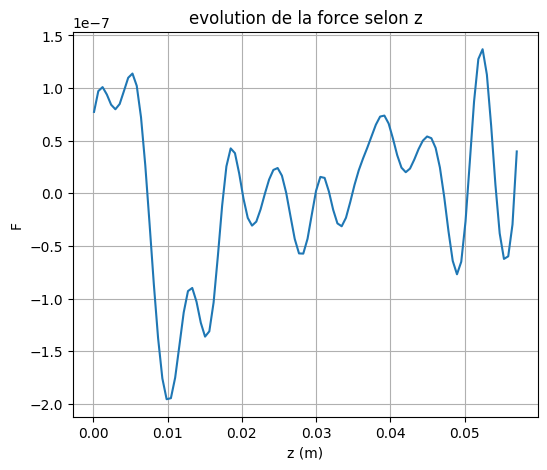

In [ ]:
X_T=np.concatenate((X_j,X2_j))
Y_T=np.concatenate((Y_j,Y2_j))
Z_T=np.concatenate((Z_j,Z2_j))


def D_F_vectorized(xj, yj, zj, x, y, z):
    theta = np.arctan(np.sqrt((x - xj)**2 + (y - yj)**2) / np.where(np.abs(z - zj) < 1e-12, 1e-12, np.abs(z - zj)))
    df = np.sin(k * R_p * np.sin(theta)) / np.where(np.sin(k * R_p * np.sin(theta)) == 0, 1e-12, k * R_p * np.sin(theta))
    df = np.where(np.isnan(df), 1, df)
    return df

# === Calcul du champ total ===

def p_tot(x, y, z, phi_vals, dj, df):
    exp_term = np.exp(1j * (k * dj + phi_vals))
    return np.sum(df / dj * exp_term)

# === Pré-calculs (ne dépendent pas des phases) ===
DJ={}
DF={}
def precompute_field_params(x, y, z):
    # Plaque du bas
    if (x,y,z) in DJ:
        return (DJ[(x,y,z)],DF[(x,y,z)])

    else :
      dx = X_T - x
      dy = Y_T - y
      dz = Z_T - z
      dj = np.sqrt(dx**2 + dy**2 + dz**2)
      df = D_F_vectorized(X_T, Y_T, Z_T, x, y, z)
      DJ[(x,y,z)]=dj
      DF[(x,y,z)]=df

      return (dj, df)

# === Gradient numérique du champ ===

def grad_p(x, y, z, phi_vals, dj0, df0):
    def shifted_p(dx, dy, dz):
        dj, df = precompute_field_params(x + dx, y + dy, z + dz)
        return p_tot(x + dx, y + dy, z + dz, phi_vals, dj, df)

    dp_dx = (shifted_p(eps, 0, 0) - shifted_p(0, 0, 0)) / eps
    dp_dy = (shifted_p(0, eps, 0) - shifted_p(0, 0, 0)) / eps
    dp_dz = (shifted_p(0, 0, eps) - shifted_p(0, 0, 0)) / eps
    return np.array([dp_dx, dp_dy, dp_dz])

# === Potentiel de Gorkov ===

def gorkov_potential(x, y, z, phi_vals, dj, df):
    p_complex = p_tot(x, y, z, phi_vals, dj, df)
    gradp = grad_p(x, y, z, phi_vals, dj, df)

    omega = 2 * np.pi * 40000
    k1 = K1(R_p, c_p, rho_p)
    k2 = K2(R_p, omega, rho_p)

    abs_p2 = abs(p_complex)**2
    abs_gradp2 = np.sum(np.abs(gradp)**2)
    return k1 * abs_p2 - k2 * abs_gradp2

# === Laplacien du potentiel ===

def Fz(x, y, z, phi_vals):
    def U_shift(dx, dy, dz):
        dj, df = precompute_field_params(x + dx, y + dy, z + dz)
        return gorkov_potential(x + dx, y + dy, z + dz, phi_vals, dj, df)

    dU_dz = (U_shift(0, 0, eps) - U_shift(0, 0, 0)) / eps
    return dU_dz

def force_verticale(Z_a, D_a=0.035):
    Z = np.linspace(0.0001, 0.057, b)
    amp=[]
    for a in Z :
      amp.append (Fz(X_foc, Y_foc, a, Phi))

    plt.figure(figsize=(6, 5))
    plt.plot(Z,amp)

    plt.title(f'evolution de la force selon z')
    plt.xlabel('z (m)')
    plt.ylabel('F')
    plt.grid()
    plt.show()

force_verticale(0.03)